# WealthNaviのポートフォリオ最適化

#### 参考URL: https://datacoach.me/investment/long-inv/python-wealthnavi/



[WealthNaviの資産運用アルゴリズム](https://www.wealthnavi.com/image/WealthNavi_WhitePaper.pdf)
- 平均分散法によって資産クラスの最適化を行う
- リスク許容度に応じた最適ポートフォリオは以下の（非線形）最大化問題の解となる資産配分比率(w)を求めることによって求まる

$$
max(\mathbf{w})  \quad  \mathbf{r^T w} - \frac{1}{2 \lambda} \mathbf{w^T \Sigma w} \\
s.t.  \  \mathbf{w^T 1}=1,  \  a \leqq \mathbf{w} \leqq b \\
$$  

$$
\begin{align}
  & \mathbf{r}: & &各資産クラスの期待リターン  \\
  & \mathbf{\Sigma}: & &分散・共分散行列  \\
  & \mathbf{w}: & &各資産クラスへの配分比率  \\
  & \mathbf{\lambda}: & &リスク許容度（1 - 5）に応じた係数  \\
  & \mathbf{a}: & &各銘柄への配分比率の下限  \\
  & \mathbf{b}: & &各銘柄への配分比率の上限  \\
\end{align}
$$ 



#### 線形・非線形問題
https://ajhjhaf.hatenablog.com/entry/2018/02/12/235015  
https://ki-chi.jp/?p=582  
https://longtweets.hatenablog.com/entry/2019/01/04/055820

- PULP　（線形問題のみ）  
    - https://coin-or.github.io/pulp/
    - https://docs.pyq.jp/python/math_opt/pulp.html
    - https://qiita.com/SaitoTsutomu/items/070ca9cb37c6b2b492f0
- CYXOPT（非線形問題に対応）
    - http://cvxopt.org/index.html
    - https://qiita.com/ryoshi81/items/8b0c6add3e367f94c828
- PyPortfolioOpt　（ポートフォリオ最適化問題に特化したパッケージ）
    - https://pyportfolioopt.readthedocs.io/en/latest/index.html
    - https://qiita.com/ryoshi81/items/c2445a5705b495002c1d
    

In [1]:
%matplotlib inline
import os, sys, math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier

## Load data

In [2]:
# correlations between asset classes

S = pd.read_csv('assetclass_correlation_202002.csv', index_col=0)

In [3]:
S

,Stock-US,Stock-Jpn/EU,Stock-Emerging,Bonds-US,Bonds-PriceLinked,Gold,RealEstate
Class,,,,,,,
Stock-US,1.0,0.9,0.7,-0.2,0.0,0.0,0.6
Stock-Jpn/EU,0.9,1.0,0.8,-0.1,0.1,0.1,0.6
Stock-Emerging,0.7,0.8,1.0,0.0,0.2,0.3,0.5
Bonds-US,-0.2,-0.1,0.0,1.0,0.8,0.4,0.3
Bonds -Price Linked,0.0,0.1,0.2,0.8,1.0,0.5,0.4
Gold,0.0,0.1,0.3,0.4,0.5,1.0,0.1
RealEstate,0.6,0.6,0.5,0.3,0.4,0.1,1.0


In [4]:
cor = S.values
#print(S.shape)

In [5]:
cor

array([[ 1. ,  0.9,  0.7, -0.2,  0. ,  0. ,  0.6],
       [ 0.9,  1. ,  0.8, -0.1,  0.1,  0.1,  0.6],
       [ 0.7,  0.8,  1. ,  0. ,  0.2,  0.3,  0.5],
       [-0.2, -0.1,  0. ,  1. ,  0.8,  0.4,  0.3],
       [ 0. ,  0.1,  0.2,  0.8,  1. ,  0.5,  0.4],
       [ 0. ,  0.1,  0.3,  0.4,  0.5,  1. ,  0.1],
       [ 0.6,  0.6,  0.5,  0.3,  0.4,  0.1,  1. ]])

In [6]:
name = list(S.columns.values)

In [7]:
name

['Stock-US',
 'Stock-Jpn/EU',
 'Stock-Emerging',
 'Bonds-US',
 'Bonds-PriceLinked',
 'Gold',
 'RealEstate']

In [8]:
# risk of each class

risk = {}
risk["Stock-US"] = 12.5/100
risk["Stock-Jpn/EU"] = 13.6/100
risk["Stock-Emerging"] = 16.7/100
risk["Bonds-US"] = 3.1/100
risk["Bonds-PriceLinked"] = 4.1/100
risk["Gold"] = 15.0/100
risk["RealEstate"] = 13.4/100

In [9]:
# convert to numpy array

risk = np.array(list(risk.values()))
#risk = risk.reshape(len(risk),1)
#print(risk.shape)

In [10]:
risk

array([0.125, 0.136, 0.167, 0.031, 0.041, 0.15 , 0.134])

In [11]:
# expected return from each class

val = {}
val["Stock-US"] = 7.2/100
val["Stock-Jpn/EU"] = 7.7/100
val["Stock-Emerging"] = (8.5+0.00000000001)/100
val["Bonds-US"] = 2.3/100
val["Bonds-PriceLinked"] = 2.6/100
val["Gold"] = 3.8/100
val["RealEstate"] = 5.7/100

In [12]:
# convert to numpy array

val = np.array(list(val.values()))
#val = val.reshape(len(val),1)
#print(val.shape)

In [13]:
val

array([0.072, 0.077, 0.085, 0.023, 0.026, 0.038, 0.057])

## Diagonalize risk vector and obtain covariance matrix using correlation matrix

In [14]:
r_diag = np.diag(risk)

In [15]:
r_diag

array([[0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.136, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.167, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.031, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.041, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.15 , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.134]])

In [16]:
cov = np.dot(np.dot(r_diag, cor), r_diag)

In [17]:
cov

array([[ 0.015625 ,  0.0153   ,  0.0146125, -0.000775 ,  0.       ,
         0.       ,  0.01005  ],
       [ 0.0153   ,  0.018496 ,  0.0181696, -0.0004216,  0.0005576,
         0.00204  ,  0.0109344],
       [ 0.0146125,  0.0181696,  0.027889 ,  0.       ,  0.0013694,
         0.007515 ,  0.011189 ],
       [-0.000775 , -0.0004216,  0.       ,  0.000961 ,  0.0010168,
         0.00186  ,  0.0012462],
       [ 0.       ,  0.0005576,  0.0013694,  0.0010168,  0.001681 ,
         0.003075 ,  0.0021976],
       [ 0.       ,  0.00204  ,  0.007515 ,  0.00186  ,  0.003075 ,
         0.0225   ,  0.00201  ],
       [ 0.01005  ,  0.0109344,  0.011189 ,  0.0012462,  0.0021976,
         0.00201  ,  0.017956 ]])

In [18]:
df = pd.DataFrame(cov, index = name, columns=name)
df

,Stock-US,Stock-Jpn/EU,Stock-Emerging,Bonds-US,Bonds-PriceLinked,Gold,RealEstate
Stock-US,0.015625,0.015300,0.014612,-0.000775,0.000000,0.000000,0.010050
Stock-Jpn/EU,0.015300,0.018496,0.018170,-0.000422,0.000558,0.002040,0.010934
Stock-Emerging,0.014612,0.018170,0.027889,0.000000,0.001369,0.007515,0.011189
Bonds-US,-0.000775,-0.000422,0.000000,0.000961,0.001017,0.001860,0.001246
Bonds-PriceLinked,0.000000,0.000558,0.001369,0.001017,0.001681,0.003075,0.002198
Gold,0.000000,0.002040,0.007515,0.001860,0.003075,0.022500,0.002010
RealEstate,0.010050,0.010934,0.011189,0.001246,0.002198,0.002010,0.017956


## Visualize asset classes

In [19]:
#plt.rcParamsDefault

In [20]:
# fontsize: xx-small, x-small, small, medium, large, x-large, xx-large
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 4),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
#plt.rcParams.update(plt.rcParamsDefault)

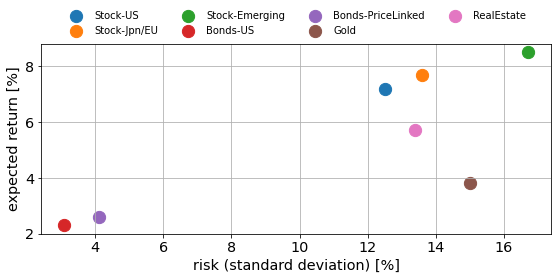

In [21]:
# figureを生成
fig = plt.figure()

# axをfigureに設定
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('risk (standard deviation) [%]')
ax.set_ylabel('expected return [%]')
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
ax.grid(True)

for i,j,k in zip(risk, val, name):
    ax.scatter(i*100, j*100, s=150, label=k)
    #ax.annotate(k, xy=(i, j))
    
#ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0, fontsize=10, frameon=False)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), borderaxespad=0, ncol=4, fontsize=10, frameon=False)

plt.tight_layout()

plt.savefig("assetclass.png")

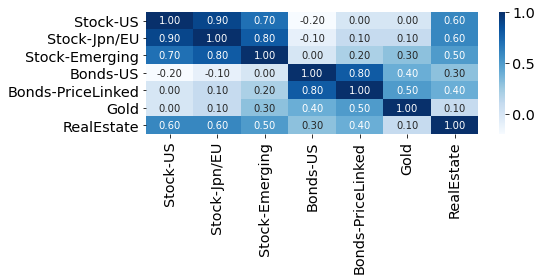

In [22]:
# heatmap
plt.figure()
sns.heatmap(cor, annot=True, xticklabels=name, yticklabels=name, cmap='Blues', fmt='.2f')
plt.tight_layout()
plt.savefig("assetclass_heatmap.png")

## Optimize asset classes with upper and lower bounds (weights of each asset class must be between 5% ~ 35%)

In [23]:
#　効率的フォロンティア (efficient frontier)を計算

vmin, vmax, vdelta = 0.04, 0.07, 0.0025     #　要求リターン: 4% ~ 7%を0.25%刻みで計算
trets = np.arange(vmin, vmax, vdelta)

# 資産クラスの重みを一律に5% ~ 35%に設定
ef = EfficientFrontier(val, df, weight_bounds=(0.05, 0.35))

In [24]:
def calc_weight(ef, trets):

    tvols = []
    tweights = []
    
    for tr in trets:
        w = ef.efficient_return(target_return=float(tr))
        #print(tr, w)
        w = pd.Series(w).values
        v = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        tvols += [v]
        tweights += [w]
        
    return tvols, tweights

In [25]:
tvols, tweights = calc_weight(ef, trets)

#### Plot

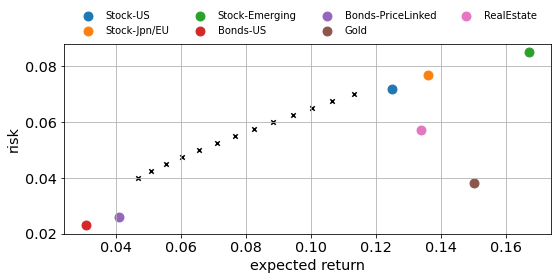

In [26]:
# figureを生成
fig = plt.figure()

# axをfigureに設定
ax = fig.add_subplot(1,1,1)


#ax.set_title('各資産クラスの期待リターンとリスク')
ax.set_xlabel('expected return')
ax.set_ylabel('risk')
ax.grid(True)


for i,j,k in zip(risk, val, name):
    ax.scatter(i, j, s=80, label=k)
    
ax.scatter(tvols, trets, marker="x", s=20, c='k')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), borderaxespad=0, ncol=4, fontsize=10, frameon=False)

plt.tight_layout()

plt.savefig("maximum_return_vs_risk.png")

In [27]:
def plot_portfolio(tweights, trets, name, ofile):

    tweights = np.array(tweights) * 100
    trets = trets * 100
    
    #dfWeights = pd.DataFrame(tweights, index = trets, columns = name)
    #dfWeights = pd.DataFrame(np.array(tweights).clip(0), index = trets, columns = name)   # convert negative values in tweights to zero
    dfWeights = pd.DataFrame(tweights.clip(0), index = trets, columns = name)   # convert negative values in tweights to zero
    dfWeights.plot.area()

    plt.xlabel("expected return [%]")
    plt.ylabel("weight [%]")
    plt.xlim(vmin*100,vmax*100)
    plt.ylim([0,100])

    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0, fontsize=14, frameon=False)
    #plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), borderaxespad=0, ncol=4, fontsize=10, frameon=False)

    plt.tight_layout()

    #plt.show()
    #plt.savefig("assetclass_opt_portfolio.png")
    plt.savefig(ofile)
    
    return dfWeights

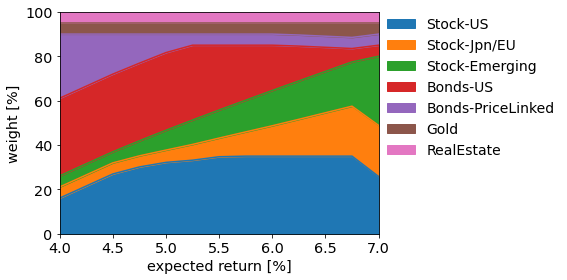

In [28]:
filename = "portfolio_with_bounds.png"
dfWeights = plot_portfolio(tweights, trets, name, filename)

### check maximum return

In [29]:
for n in name:
    print("{:18s} maximum return: {:6.2f}%    risk level: {:4.2f}%".format(n, np.round(dfWeights[n].max(),2), np.round(dfWeights[n].idxmax(),2)))

Stock-US           maximum return:  35.00%    risk level: 5.75%
Stock-Jpn/EU       maximum return:  23.02%    risk level: 7.00%
Stock-Emerging     maximum return:  31.14%    risk level: 7.00%
Bonds-US           maximum return:  35.00%    risk level: 4.00%
Bonds-PriceLinked  maximum return:  28.91%    risk level: 4.00%
Gold               maximum return:   6.50%    risk level: 6.75%
RealEstate         maximum return:   5.00%    risk level: 4.00%


In [30]:
dfWeights.loc[dfWeights["Stock-US"].idxmax()]

Stock-US             35.000000
Stock-Jpn/EU         10.924267
Stock-Emerging       14.275638
Bonds-US             24.800095
Bonds-PriceLinked     5.000000
Gold                  5.000000
RealEstate            5.000000
Name: 5.750000000000002, dtype: float64

In [31]:
dfWeights.tail(20)

,Stock-US,Stock-Jpn/EU,Stock-Emerging,Bonds-US,Bonds-PriceLinked,Gold,RealEstate
4.00,16.086957,5.000000,5.000000,35.000000,28.913043,5.000000,5.0
4.25,21.521739,5.000000,5.000000,35.000000,23.478261,5.000000,5.0
4.50,26.956522,5.000000,5.000000,35.000000,18.043478,5.000000,5.0
4.75,30.128784,5.000000,6.763999,35.000000,13.107217,5.000000,5.0
5.00,32.187122,5.538675,8.930847,35.000000,8.343356,5.000000,5.0
5.25,33.169798,7.108879,10.980651,33.740671,5.000000,5.000000,5.0
5.50,34.727903,8.413281,12.645413,29.213404,5.000000,5.000000,5.0
5.75,35.000000,10.924267,14.275638,24.800095,5.000000,5.000000,5.0
6.00,35.000000,13.690546,15.898556,20.410897,5.000000,5.000000,5.0
6.25,35.000000,16.601166,17.296213,15.691166,5.000000,5.411455,5.0


## Optimize asset classes without upper and lower bounds

In [32]:
#　効率的フォロンティア (efficient frontier)を計算

vmin, vmax, vdelta = 0.03, 0.085, 0.001     #　要求リターン: 3% ~ 8.5%を0.1%刻みで計算
trets = np.arange(vmin, vmax, vdelta)
#print(trets)

ef = EfficientFrontier(val, df)

In [33]:
tvols, tweights = calc_weight(ef, trets)

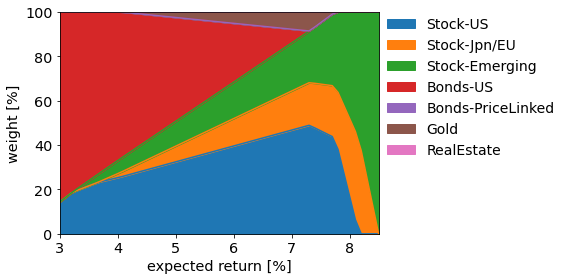

In [34]:
filename = "portfolio_without_bounds.png"
dfWeights = plot_portfolio(tweights, trets, name, filename)

#### check maximum return

In [35]:
for n in name:
    print("{:18s} maximum return: {:6.2f}%    risk level: {:4.2f}%".format(n, np.round(dfWeights[n].max(),2), np.round(dfWeights[n].idxmax(),2)))

Stock-US           maximum return:  48.89%    risk level: 7.30%
Stock-Jpn/EU       maximum return:  39.75%    risk level: 8.10%
Stock-Emerging     maximum return: 100.00%    risk level: 8.50%
Bonds-US           maximum return:  85.71%    risk level: 3.00%
Bonds-PriceLinked  maximum return:   0.00%    risk level: 3.00%
Gold               maximum return:   8.57%    risk level: 7.30%
RealEstate         maximum return:   0.00%    risk level: 3.00%


In [36]:
dfWeights.loc[dfWeights["Stock-US"].idxmax()]

Stock-US             48.888842
Stock-Jpn/EU         19.176462
Stock-Emerging       23.231503
Bonds-US              0.132218
Bonds-PriceLinked     0.000000
Gold                  8.570976
RealEstate            0.000000
Name: 7.300000000000003, dtype: float64

In [37]:
dfWeights

,Stock-US,Stock-Jpn/EU,Stock-Emerging,Bonds-US,Bonds-PriceLinked,Gold,RealEstate
3.0,14.285714,0.000000e+00,0.000000,85.714286,0.0,0.000000,0.0
3.1,16.326531,0.000000e+00,0.000000,83.673469,0.0,0.000000,0.0
3.2,18.367347,0.000000e+00,0.000000,81.632653,0.0,0.000000,0.0
3.3,19.556285,0.000000e+00,0.673259,79.770456,0.0,0.000000,0.0
3.4,20.565217,0.000000e+00,1.488780,77.946003,0.0,0.000000,0.0
3.5,21.574149,0.000000e+00,2.304302,76.121549,0.0,0.000000,0.0
3.6,22.583081,0.000000e+00,3.119823,74.297096,0.0,0.000000,0.0
3.7,23.423552,2.278926e-01,3.869996,72.478559,0.0,0.000000,0.0
3.8,24.046794,7.496533e-01,4.535900,70.667652,0.0,0.000000,0.0
3.9,24.670036,1.271414e+00,5.201805,68.856746,0.0,0.000000,0.0
